In [2]:
import time
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


! apt-get install -y graphviz-dev
! pip install pygraphviz
! apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## Датасет

In [3]:
from google.colab import files

files.upload();

Saving imdb_dataset_filtered.csv to imdb_dataset_filtered (1).csv


In [4]:
!ls -la

total 3304
drwxr-xr-x 1 root root    4096 Mar 26 19:53  .
drwxr-xr-x 1 root root    4096 Mar 26 19:40  ..
drwxr-xr-x 1 root root    4096 Mar 25 16:11  .config
-rw-r--r-- 1 root root 1683385 Mar 26 19:54 'imdb_dataset_filtered (1).csv'
-rw-r--r-- 1 root root 1683385 Mar 26 19:43  imdb_dataset_filtered.csv
drwxr-xr-x 1 root root    4096 Mar 18 16:23  sample_data


In [27]:
df = pd.read_csv('./imdb_dataset_filtered.csv').sample(frac=0.1, random_state=42)
df

,titleId,title,directorId,director,year,titleType,isAdult,runtimeMins,genres,avgRating,numVotes,region,language,types,isOriginalTitle
11965,tt0433692,Sepet,nm1379108,Yasmin Ahmad,2004,movie,0,104,\N,7.2,537,GR,\N,festival,0
11188,tt1364189,Bahoz,nm1078399,Kazim Öz,2008,movie,0,156,\N,7.3,771,TR,tr,imdbDisplay,0
14336,tt11163014,Mike Birbiglia: The New One,nm0057592,Seth Barrish,2019,tvSpecial,0,85,\N,7.6,1008,\N,\N,original,1
1355,tt0055597,Victim,nm0213136,Basil Dearden,1961,movie,0,90,\N,7.7,4655,XYU,sr,\N,0
1470,tt0052151,Run Silent Run Deep,nm0936404,Robert Wise,1958,movie,0,93,\N,7.3,9704,RO,\N,\N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,tt0088334,Urusei Yatsura 2: Byûtifuru dorîmâ,nm0651900,Mamoru Oshii,1984,movie,0,98,\N,7.5,1573,\N,\N,\N,0
13791,tt6304968,Teleioi xenoi,nm0040440,Thodoris Atheridis,2016,movie,0,92,\N,7.1,1435,\N,\N,original,1
10680,tt10656240,Bebas,nm0729764,Riri Riza,2019,movie,0,119,\N,7.4,305,\N,\N,original,1
6153,tt0095953,Rain Man,nm0001469,Barry Levinson,1988,movie,0,133,\N,8.0,455157,BG,bg,imdbDisplay,0


## Составляем графы

In [0]:
# Два вида нодов - фильмы и режиссеры. Связи по году съемки между фильмом и режиссёром и по типу между фильмами.
def get_graph(df):
  d = {}
  for index, row in df.iterrows():
    d[row['titleId']] = json.loads(row[['directorId', 'year', 'region', 'runtimeMins', 'titleType']].to_json())
    d[row['directorId']] = json.loads(row[['director']].to_json())

  graph = nx.Graph()
  for key, value in d.items():
    if key[:2] == 'nm':
      graph.add_node(key, director=value['director'])
    elif key[:2] == 'tt':
      graph.add_node(key, directorId=value['directorId'], year=value['year'], region=value['region'], runtimeMins='runtimeMins', titleType='titleType')

  for i, row_i in df.iterrows():
    graph.add_edge(row_i['titleId'], row_i['directorId'], color='red')

  for key, group in df.groupby('titleType'):
    for i, row_i in group.iterrows():
      for j, row_j in group.iterrows():
        if i != j:
          graph.add_edge(row_i['titleId'], row_j['titleId'], color='green')

  node_color = np.asarray(['blue' if x[:2]=='tt' else 'yellow' for x in list(graph.nodes)])
  edge_color = [graph[u][v]['color'] for u,v in graph.edges()]

  return graph, node_color, edge_color

## Алгоритмы

In [0]:
# distances_layout

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def distances_layout(G, distance=1, diameter=False):
    center = np.zeros(2)
    components = connected_component_subgraphs(G)

    if len(G) == 0:
        pos = {}
        path_labels = {}
    elif len(G) == 1:
        pos = {nx.utils.arbitrary_element(G): center}
        path_labels = {nx.utils.arbitrary_element(G): '0'}
    else:
        pos = {}
        path_labels = {}
        for comp in components:
            if diameter:
                ecc = nx.eccentricity(comp)
                p = dict(nx.single_source_shortest_path_length(comp, max(ecc, key=ecc.get)))
            else:
                p = dict(nx.single_source_shortest_path_length(comp, np.random.choice(list(comp.nodes))))
            Distances = {}
            for node in p:
                if p[node] not in Distances:
                    Distances[p[node]] = [node]
                else:
                    Distances[p[node]].append(node)
            max_elems = 0
            for dist in Distances:
                num_elems = len(Distances[dist])
                if max_elems < num_elems:
                    max_elems = num_elems
            center[1] -= max(3, np.sqrt(max_elems))
            for dist in Distances:
                num_elems = len(Distances[dist])
                ys = np.linspace(-np.sqrt(num_elems), np.sqrt(num_elems), num_elems + 2)[1:-1]
                xs = np.repeat(dist * distance, num_elems)
                cur_pos = np.column_stack([xs, ys]) + center
                cur_labels = np.repeat(dist, num_elems).astype(str)
                pos.update(dict(zip(Distances[dist], cur_pos)))
                path_labels.update(dict(zip(Distances[dist], cur_labels)))
            center[1] -= max(3, np.sqrt(max_elems))

    return pos, path_labels

In [0]:
def furthest(G, source):
    if source not in G:
        print("source not in G")
        return nx.Graph(), []
    else:
        for comp in connected_component_subgraphs(G):
            if source in comp:
                our_comp = comp
                p = dict(nx.single_source_shortest_path_length(comp, source))
        Distances = {}
        for node in p:
            if p[node] not in Distances:
                Distances[p[node]] = [node]
            else:
                Distances[p[node]].append(node)
        most_remotes = Distances[max(Distances)]
        our_nodes = set()
        
        for remote in most_remotes:
            our_nodes.update(nx.shortest_path(our_comp, source=source, target=remote))

    return our_comp.subgraph(our_nodes), most_remotes

## Строительство

In [0]:
graph, node_color, edge_color = get_graph(df)

In [29]:
directorIds = df['directorId'].unique()
directorIds[:5]

array(['nm1379108', 'nm1078399', 'nm0057592', 'nm0213136', 'nm0936404'],
      dtype=object)

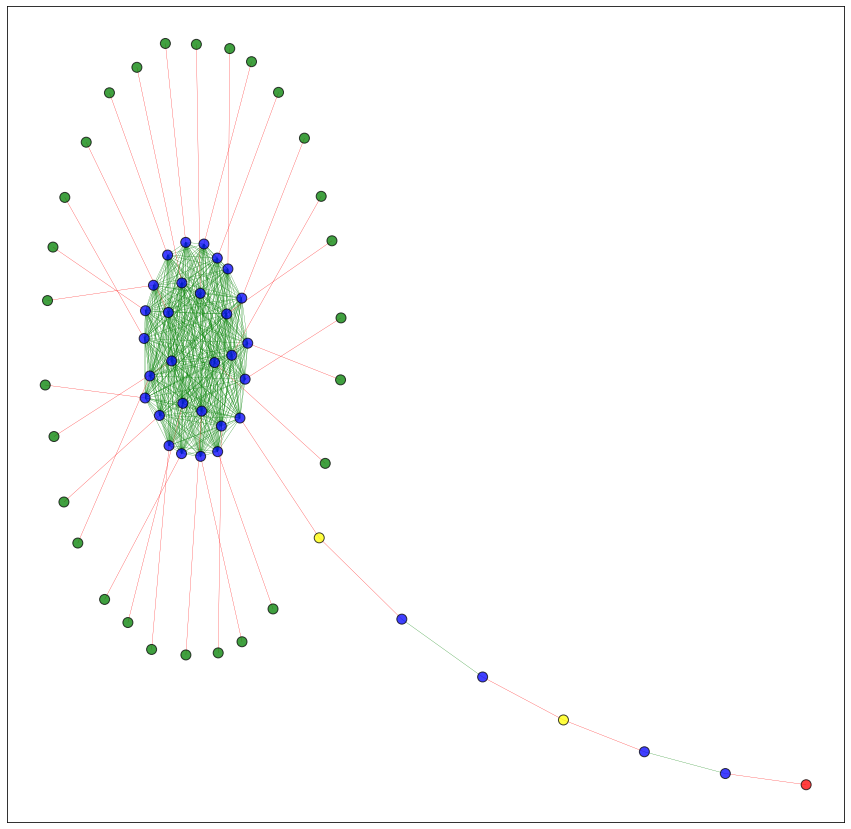

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

source = 'nm1078399'
subgraph, remotes = furthest(graph, source)
pos = nx.drawing.nx_pydot.pydot_layout(subgraph, 'neato')

node_color = []
for x in list(subgraph.nodes):
    if x == source:
        node_color.append('red')
    elif x in remotes:
        node_color.append('green')
    elif x[:2] == "tt":
        node_color.append("blue")
    else:
        node_color.append("yellow")
edge_color = [graph[u][v]['color'] for u,v in subgraph.edges()]

nx.draw_networkx_nodes(G=subgraph,
                      pos=pos,
                      node_color=node_color,
                      # cmap=plt.cm.Blues,
                      node_size=100,
                      node_shape='o',
                      alpha=0.75,
                      edgecolors='black',
                      ax=ax)

nx.draw_networkx_edges(G=subgraph,
                      pos=pos,
                      edge_color=edge_color,
                      width=0.25,
                      ax=ax)

fig.savefig('result.png', dpi=fig.dpi)

In [0]:
files.download('result.png')